Viscoplastic thermal convection in a 2-D square box: Tosi et al. 2015
=====

This series of notebooks generates benchmark models from the Tosi et al. (2015) in Underworld2. The Underworld2 results are then directly compared to the results from Table 2 of Tosi et al. (2015) the paper for each case. The notebooks are broken into a general notebook for reproducing the models from scratch and 5 post-analysis notebooks which look at the results Underworld2 gives for each case after running to equilibrium. 

Case 2: Mobile lid
-------

This case has a temperature and strain rate-dependent nonlinear rheology which results in a stagnant lid mode of convection. 
The parameters used for case 4 are: $Ra = 10^2$, $\Delta \eta_T = 10^5$, $\eta^* = 10^{-3}$, $\Delta \eta_z = 1$ and $\sigma_\gamma = 1$.


References
-----

1. Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [1]:
%matplotlib inline
import underworld as uw
import math
from underworld import function as fn
import glucifer
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import time
import numpy as np
import os

Set physical constants and parameters, including the Rayleigh number (*Ra*) and viscosity constants ($\eta^*$ and $\eta_T$) which are common to all Tosi et al cases.

In [2]:
RA  = 1e2        # Rayleigh number
ETA_T = 1e5      # common viscosity constant
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA0 = 1e-3      # viscosity constant eta^* in Tosi et al
TMAX = 3.0
IMAX = 1000

Select case 2 of Tosi et al (2015) and set constants as required.

In [3]:
CASE = 2
ETA_Y = 1.
YSTRESS = 1.

Set input and output file directories

In [4]:
# input file directory
inputPath  = 'TosiInput/case' + str(CASE) + "/"
# output files
outputPath = 'TosiOutput/'
filePath   = outputPath+'files'
# make directories if they don't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
if not os.path.isdir(filePath):
    os.makedirs(filePath)

Create mesh and finite element variables
------

Set up mesh and field variables that are solved on the mesh.

In [5]:
res = 128
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

Load all variable fields and summary data with data from previously run cases.

In [6]:
# load fields
temperatureField.load(    inputPath+'temperatureField.h5' )
temperatureDotField.load( inputPath+'temperatureDotField.h5' )
pressureField.load(       inputPath+'pressureField.h5')
velocityField.load(       inputPath+'velocityField.h5')

# load past iterations of summary data
data = np.loadtxt( inputPath+'Summary.txt', unpack=True )
stepsVal = data[0].tolist()
timeVal = data[1].tolist()
viscdisVal = data[2].tolist()
nu0Val = data[3].tolist()
nu1Val = data[4].tolist()
Avg_tempVal = data[5].tolist()
vrmsVal = data[6].tolist()
Rms_surfVal = data[7].tolist()
Max_vx_surfVal = data[8].tolist()
GravworkVal = data[9].tolist()
etamaxVal = data[10].tolist()
etaminVal = data[11].tolist() 

**Conditions on the boundaries**

In [7]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

Set up material parameters and functions
-----


**Viscosity field**

The viscosity is a function of temperature ($T$), the vertical coordinate ($z$) and the strain rate ($\dot{\epsilon}$) and is given by

$$
    \eta(T, z, \dot{\epsilon}) = 2 \left( \frac{1}{\eta_{lin}(T,z)} + \frac{1}{\eta_{plast}(\dot{\epsilon})} \right)^{-1}
$$

where the linear part is

$$
    \eta_{lin}(T, z) = \exp(-\gamma_T T + \gamma_z z)
$$

with $\gamma_T = \ln(\Delta \eta_T)$ and $\gamma_z = \ln(\Delta \eta_z)$. The nonlinear part is

$$
    \eta_{plast}(\dot{\epsilon}) = \eta^* + \frac{\sigma_{\gamma}}{\sqrt{\dot{\epsilon} : \dot{\epsilon}}}
$$

where $\eta^*$ is the effective viscosity at high stresses and $\sigma_{\gamma}$ is the yield stress. The values of $\Delta \eta_T$, $\Delta \eta_z$, $\eta^*$ and $\sigma_{\gamma}$ are assumed to be constant with values dependent on the particular case.

**Create variables required for plasticity calculations**

In [8]:
secinv = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.gradientFn ) )
coordinate = fn.coord()

**Setup viscosity functions**

Remember to use floats everywhere when setting up functions

In [9]:
viscosityl1 = fn.math.exp(math.log(ETA_T)*-1.*temperatureField)
viscosityl2 = fn.math.exp((math.log(ETA_T)*-1.*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinv/math.sqrt(0.5)) #extra factor to account for underworld second invariant form

if CASE == 1:
    viscosityFn = viscosityl1
elif CASE == 2:
    viscosityFn = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    viscosityFn = viscosityl2
else:
    viscosityFn = 2./(1./viscosityl2 + 1./viscosityp)

**Add functions for density and buoyancy**

In [10]:
densityFn = RA*temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Build the Stokes system and solvers
------

Setup the Stokes system with linear or nonlinear visocity viscosity depending on case.

In [11]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn), 
                              bodyForceFn=buoyancyFn)

Setup solver for the Stokes system of equations

In [12]:
solver = uw.systems.Solver( stokesPIC )

We do one solve for initial pressure and velocity with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [13]:
solver.solve( nonLinearIterate=False )

Create an advective-diffusive system
-----

Setup the system in underworld by flagging the temperature and velocity field variables.

In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField,
                                         diffusivity=1., conditions=[tempBC,] )

Metrics for benchmark
-----

Define diagnostic functions to be used in the time loop and/or measured after reaching steady state:

* Average temperature
$$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers
$$Nu_{top/bot} = - \left. \int^1_0 \frac{\partial T}{\partial y} \right|_{y=1/y=0} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
$$u_{RMS} = \left( \int_0^1 \int_0^1 \left( u_x^2 + u_y^2 \right) dx dy \right)^{1/2}$$
$$u_{RMS}^{surf} = \left( \left. \int_0^1 u_x^2\right|_{y=1} dx \right)^{1/2}$$
$$u_{max}^{surf} = \left. \max(u_x)\right|_{y=1}$$
* max and min viscosity over the whole domain
$$\eta_{max/min} = \max / \min \left( \eta\left(x,y\right) \right)$$
* average rate of work done against gravity
$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation
$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

**Setup volume integrals used in metric functions**

In [15]:
# temperature
tempint = uw.utils.Integral( temperatureField, mesh )
# area
areaint = uw.utils.Integral( 1.,               mesh )
# velocity squared
v2int   = uw.utils.Integral(fn.math.dot(velocityField,velocityField), mesh)
# work done
dwint   = uw.utils.Integral(temperatureField*velocityField[1], mesh)
# viscous dissipation
sinner = fn.math.dot(secinv,secinv)
vdint = uw.utils.Integral((4.*viscosityFn*sinner), mesh)

**Setup surface integrals used in metric functions**

In [16]:
rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.gradientFn[1], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.gradientFn[1], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

**Define diagnostic functions using integrals**

In [17]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [18]:
#Fields for saving data / fields
rmsField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
rmsfn    = fn.math.sqrt( fn.math.dot( velocityField, velocityField ) )
rmsdata  = rmsfn.evaluate( mesh )
rmsField.data[:] = rmsdata 

viscField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
viscdata  = viscosityFn.evaluate( mesh )
viscField.data[:] = viscdata

stressField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1)
srtdata     = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.gradientFn ) )
rostfield   = srtdata.evaluate( mesh )
stressinv   = 2*viscdata*rostfield[:]
stressField.data[:] = stressinv

Main simulation loop
------

Normally a loop over time increments would be added here. As we are only interested in the post-analysis a single time step will be taken to ensure that all analysis fields are live. This step will involve the non-linear Stokes system solver.

In [19]:
steps_todo = 1

Initialise steps and time. Set to zero unless loading values from file.

In [20]:
try:
    realtime = timeVal[-1]
    step = int(stepsVal[-1])
except:
    realtime = 0.0
    step = 0
steps_end = step + steps_todo
steps_output = 100
steps_output = max(steps_output,1)
print('This model has previously completed {0:6d} steps to get to time = {1:.3f}'.format(step,realtime))

This model has previously completed  43600 steps to get to time = 0.301


In [21]:
# initialise timer for computation
start = time.clock()
# start loop
while step < steps_end:
    # Solve non-linear system
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    # Calculate the Metrics, only on 1 of the processors:
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf(velocityField, mesh)
    Gravwork = gravwork(dwint)
    Viscdis = viscdis(vdint)
    nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
    etamax, etamin = visc_extr(viscosityFn)
    # store results
    stepsVal.append(       step)
    timeVal.append(        realtime )
    viscdisVal.append(     Viscdis )
    nu0Val.append(         nu0 )
    nu1Val.append(         nu1 )
    Avg_tempVal.append(    Avg_temp )
    vrmsVal.append(        Rms )
    Rms_surfVal.append(    Rms_surf )
    Max_vx_surfVal.append( Max_vx_surf )
    GravworkVal.append(    Gravwork )
    etamaxVal.append(      etamax )
    etaminVal.append(      etamin )

    # output fields and summary info to file (output graphics can also be added here)
    if uw.rank()==0:
        if (step % steps_output == 0) or (step == steps_end-1):
            print 'step =',step, '; CPU time =', time.clock()-start, '; vrms = ',Rms
            # Temperature
            fnametemp = "temperatureField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            temperatureField.save(fullpath)
            # Temperature time derivative
            fnametemp = "temperatureDotField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            temperatureDotField.save(fullpath)
            # Pressure
            fnametemp = "pressureField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            pressureField.save(fullpath)
            # Velocity
            fnametemp = "velocityField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            velocityField.save(fullpath)

            np.savetxt( outputPath + 'Summary.txt', np.c_[stepsVal, timeVal, viscdisVal, nu0Val, 
                                                          nu1Val, Avg_tempVal, vrmsVal, Rms_surfVal,
                                                         Max_vx_surfVal, GravworkVal, etamaxVal, etaminVal], 
                   header="Steps, Time, visc, Nusselt bottom/top, av_T, vrms, surf_rms, surf_max, grav, etamax, etamin" )

Post-simulation analysis
-------

Here we will calculate the quantities specified for this case in Tosi et al. (2015) and finally compare them to the values given in their Table 2.

**Plot final temperature and velocity fields**


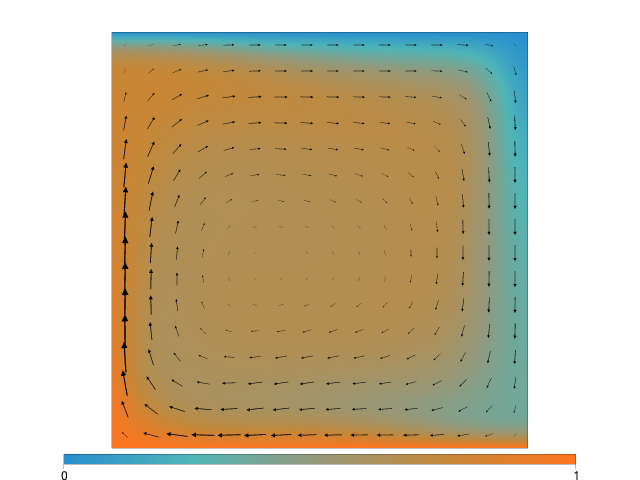

In [25]:
velmax = np.amax(velocityField.data[:])
if(velmax==0.0): velmax = 1.0
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Surface(mesh, temperatureField) )
fig1.append( glucifer.objects.VectorArrows( mesh, velocityField/velmax, scaling=0.1, arrowHead=0.2 ) )
fig1.show()

**Calculate quantities for benchmark comparison**

In [23]:
tempAv = Avg_tempVal[-1]
nuTop = nu1Val[-1]
nuBot = nu0Val[-1]
uRMS = vrmsVal[-1]
uSurfRMS = Rms_surfVal[-1]
uSurfMax = Max_vx_surfVal[-1]
etaMin = etaminVal[-1]
etaMax = etamaxVal[-1]
workDone = GravworkVal[-1]
phi = viscdisVal[-1]/100.
delta = abs(workDone - phi)/max(workDone, phi) * 100.

**Output all quantities for this case**

In [24]:
print('<T>        = {0:.4f}'.format(tempAv))
print('Nu_top     = {0:.4f}'.format(nuTop))
print('Nu_bot     = {0:.4f}'.format(nuBot))
print('u_rms      = {0:.4f}'.format(uRMS))
print('u^surf_rms = {0:.4f}'.format(uSurfRMS))
print('u^surf_max = {0:.4f}'.format(uSurfMax))
print('eta_min    = {0:.4e}'.format(etaMin))
print('eta_max    = {0:.4f}'.format(etaMax))
print('W          = {0:.4f}'.format(workDone))
print('Phi        = {0:.4f}'.format(phi))
print('delta      = {0:.4f}%'.format(delta))

<T>        = 0.5994
Nu_top     = 8.4725
Nu_bot     = 8.5378
u_rms      = 138.8916
u^surf_rms = 103.8739
u^surf_max = 120.9129
eta_min    = 1.9854e-05
eta_max    = 1.6685
W          = 7.4987
Phi        = 7.5242
delta      = 0.3382%


**Comparison values from Tosi et al. (2015)**

The expected benchmark values from Table 2 of Tosi et al. (2015) for case 2 are given in the table below. The minimum and maximum values from each of the participating codes are given here to provide an expected range for each quantity.

| Case 2  | $<$$T$$>$ | $Nu_{top}$ | $Nu_{bot}$ | $u_{RMS}$ | $u_{RMS}^{surf}$ | $u_{max}^{surf}$ | $\eta_{min}$ | $\eta_{max}$ | $<$$W$$>$ |  $<$$\Phi$$>$/Ra | $\delta$ |
|:--------|:---------:|:----------:|:----------:|:---------:|:----------------:|:----------------:|:------------:|:------------:|:------------:|:------------------:|:--------:|
| Min     | 0.6027 | 8.5217 | 8.5217 | 140.1871 | 102.8500 | 119.4120 | 1.9850$\times 10^{-5}$ | 1.0400 | 7.5199 | 7.4690 | $<$0.01% |
| Max     | 0.6071 | 8.7475 | 8.6489 | 143.8518 | 105.1767 | 122.9754 | 2.0800$\times 10^{-5}$ | 1.9421 | 7.6400 | 7.6422 | 0.68% |

Note that the values from the spectral code MC3D are not used to construct the min/max values here, as they are outlier values.